### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            # label.set_size(8)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


### Plot kumulatif

Take initial varian plus "G"

In [7]:
df_G = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "G"].copy()
df_G

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
22,2021-01-07,SUMINI,BABULU DARAT,BABULU DARAT,BABULU,PEREMPUAN,1978-12-07,Wiraswasta-Perdagangan,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GB3,G,INDIVIDU,46
99,2021-01-27,BUDI,JL PERUM POLDA,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,1974-02-01,LAIN-LAIN,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GF4,G,INDIVIDU,51
102,2021-01-28,"SAIPUL HOLIS, SE",JL SYARIFUDDIN YOES,SEPINGGAN BARU,BALIKPAPAN SELATAN,LAKI-LAKI,1969-10-18,Pegawai Swasta-Jasa,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SARJANA,GF4,G,INDIVIDU,55
172,2021-02-22,SULATI,JL BUKIT PELAJAR,BARU TENGAH,BALIKPAPAN BARAT,PEREMPUAN,1972-02-27,Wiraswasta-Perdagangan,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GB3,G,INDIVIDU,53
288,2021-03-23,SARINAH,BULUMINUNG,BULUMINUNG,PENAJAM,PEREMPUAN,1980-12-01,Pegawai Swasta-Pertanian,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,GF4,G,INDIVIDU,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6780,2024-08-21,PT JAYACOM PERSADA MANDIRI,JL MT HARYONO,GUNUNG BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,2003-01-01,Wiraswasta-Jasa,"> Rp. 6.000.000,-",SLTA/SMU,GD4,G,INDIVIDU,22
6790,2024-08-22,PT. ARKANANTA APTA PRATISTA,JL MT HARYONO,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,2006-08-22,Wiraswasta-Jasa,"> Rp. 6.000.000,-",SLTA/SMU,GD4,G,INDIVIDU,18
6794,2024-08-23,AGUSWANTO,JL.SULAWESI,KARANG REJO,BALIKPAPAN TENGAH,LAKI-LAKI,1972-07-08,Pegawai Swasta-Jasa,"> Rp. 6.000.000,-",SLTA/SMU,GF5,G,INDIVIDU,52
6803,2024-08-24,HENDRA TAMBA,JL KOLONEL SYARIFUDDIN YOES,SEPINGGAN BARU,BALIKPAPAN SELATAN,LAKI-LAKI,1990-01-05,MAHASISWA/PELAJAR,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GD4,G,INDIVIDU,35


Plot data initial varian plus "G"

In [8]:
df_G_count = df_G[["Tgl. Mohon"]].copy()
df_G_count["count"] = 1.
df_G_count = df_G_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_G_count["cumulative_sum"] = df_G_count["count"].cumsum()
df_G_count

,Tgl. Mohon,count,cumulative_sum
0,2021-01-07,1,1
1,2021-01-27,1,2
2,2021-01-28,1,3
3,2021-02-22,1,4
4,2021-03-23,1,5
...,...,...,...
171,2024-08-21,1,233
172,2024-08-22,1,234
173,2024-08-23,1,235
174,2024-08-24,1,236


Groub by weekly

In [9]:
df_G_weekly = df_G_count[["Tgl. Mohon"]].copy()
df_G_count["Tgl. Mohon"] = pd.to_datetime(df_G_count["Tgl. Mohon"])

df_G_weekly = (df_G.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_G_weekly["cumulative_sum"] = df_G_weekly["count"].cumsum()
df_G_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-01-11,1,1
1,2021-01-18,0,1
2,2021-01-25,0,1
3,2021-02-01,2,3
4,2021-02-08,0,3
...,...,...,...
186,2024-08-05,2,232
187,2024-08-12,0,232
188,2024-08-19,0,232
189,2024-08-26,4,236


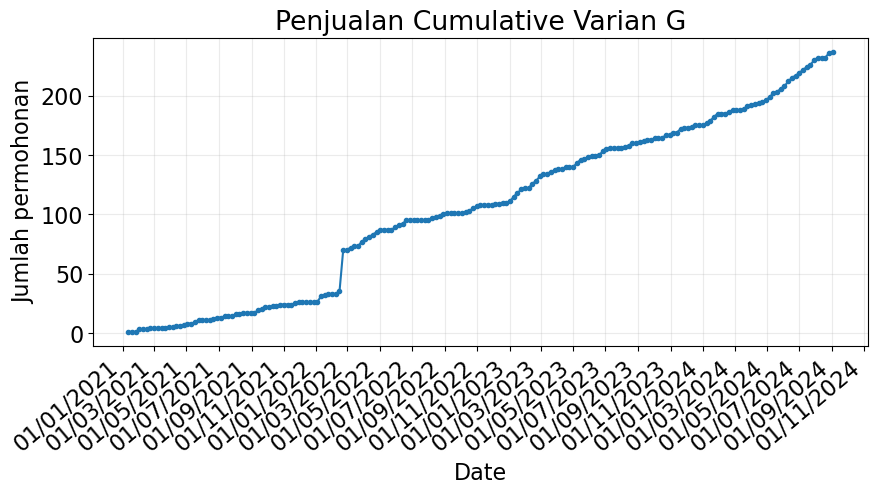

In [10]:
plot_time_series(df_G_weekly["Tgl. Mohon"], df_G_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian G",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [11]:
ADF_result = adfuller(df_G_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 0.9014151852127023
p-value: 0.993108767112226


fisrt diff (_d_=1)

In [12]:
G_diff_week = np.diff(df_G_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(G_diff_week)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -13.21378368994416
p-value: 1.034296253177957e-24


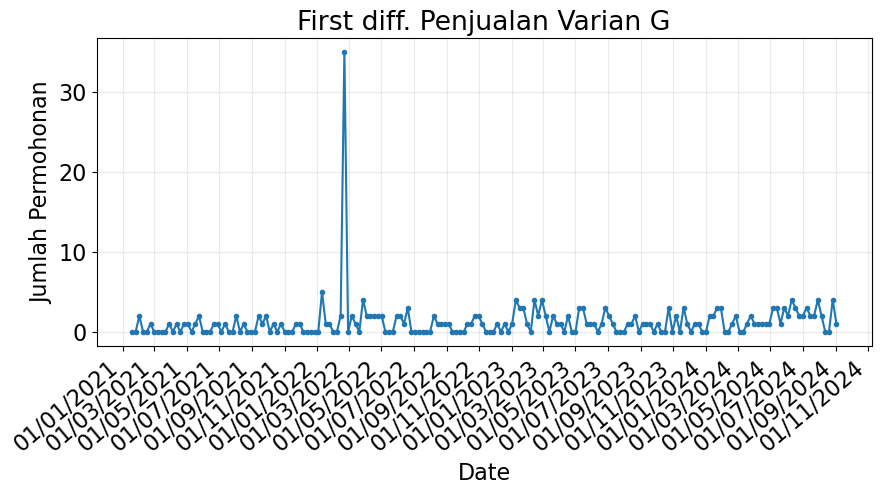

In [13]:
plot_time_series(df_G_weekly["Tgl. Mohon"].iloc[1:], G_diff_week, 
                 title="First diff. Penjualan Varian G",
                 xlabel="Date", ylabel="Jumlah Permohonan")

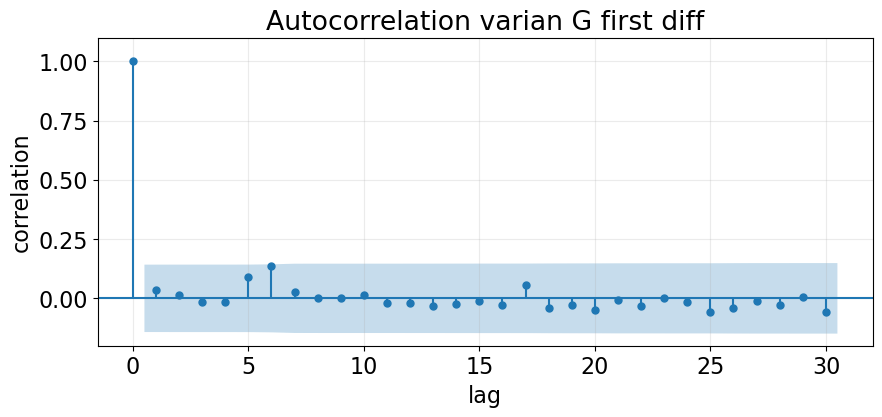

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(G_diff_week, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian G first diff")
ax.grid("on")

plt.show(fig)

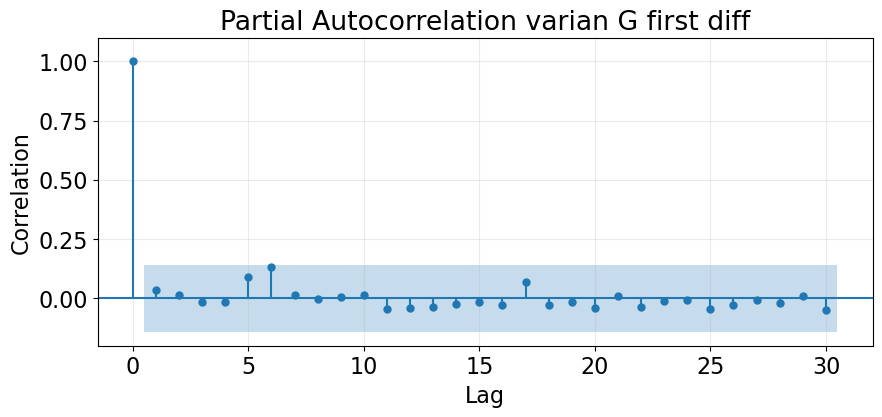

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(G_diff_week, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian G first diff")
ax.grid("on")

plt.show()

#### harian

In [16]:
ADF_result = adfuller(df_G_count["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -1.0951166137433086
p-value: 0.7170154089094972


In [17]:
G_diff = np.diff(df_G_count["cumulative_sum"], n=1)
ADF_result = adfuller(G_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -13.25401524782786
p-value: 8.66083954827745e-25


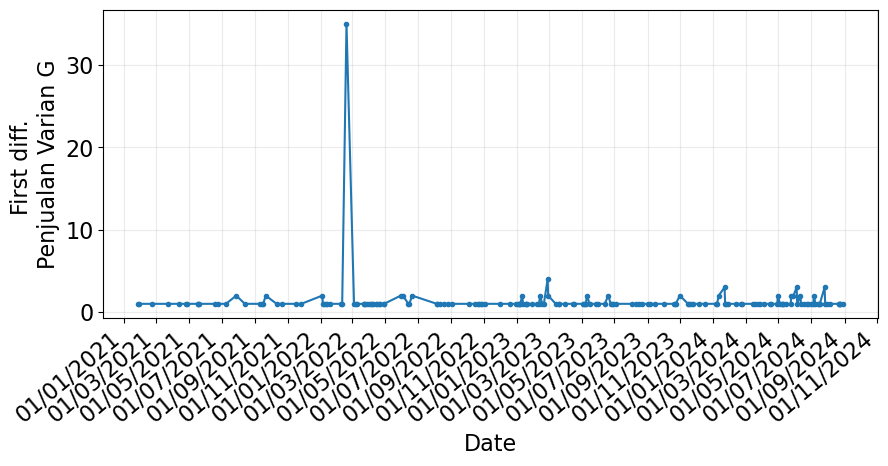

In [18]:
plot_time_series(df_G_count["Tgl. Mohon"].iloc[1:], G_diff, 
                #  title="First diff. Penjualan Varian G",
                 xlabel="Date", ylabel="First diff. \nPenjualan Varian G")

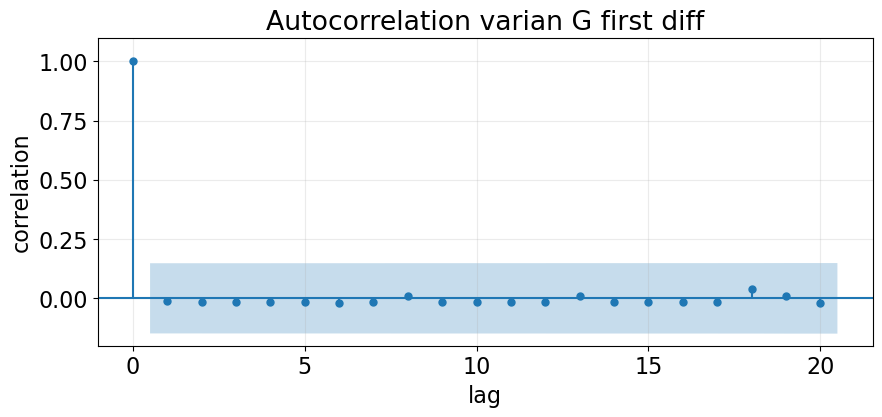

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(G_diff, lags=20, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian G first diff")
ax.grid("on")

plt.show(fig)

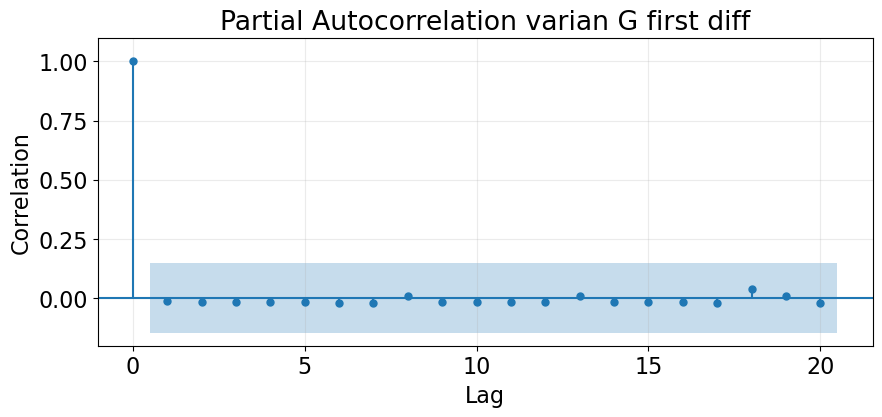

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(G_diff, lags=20, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian G first diff")
ax.grid("on")

plt.show()

gaada lag yang signifikan pada acf dan pacf = random walk

### Data Splitting

In [21]:
min_length = min(len(df_G_count["Tgl. Mohon"].iloc[1:]), len(G_diff))

df_G_random_walk = pd.DataFrame({
    "Tgl. Mohon": df_G_count["Tgl. Mohon"].iloc[1:min_length+1].values,
    "G_diff": G_diff[:min_length]
})

split_idx = int(0.8 * len(df_G_random_walk))
df_train = df_G_random_walk.iloc[:split_idx].copy()
df_test = df_G_random_walk.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (140, 35)


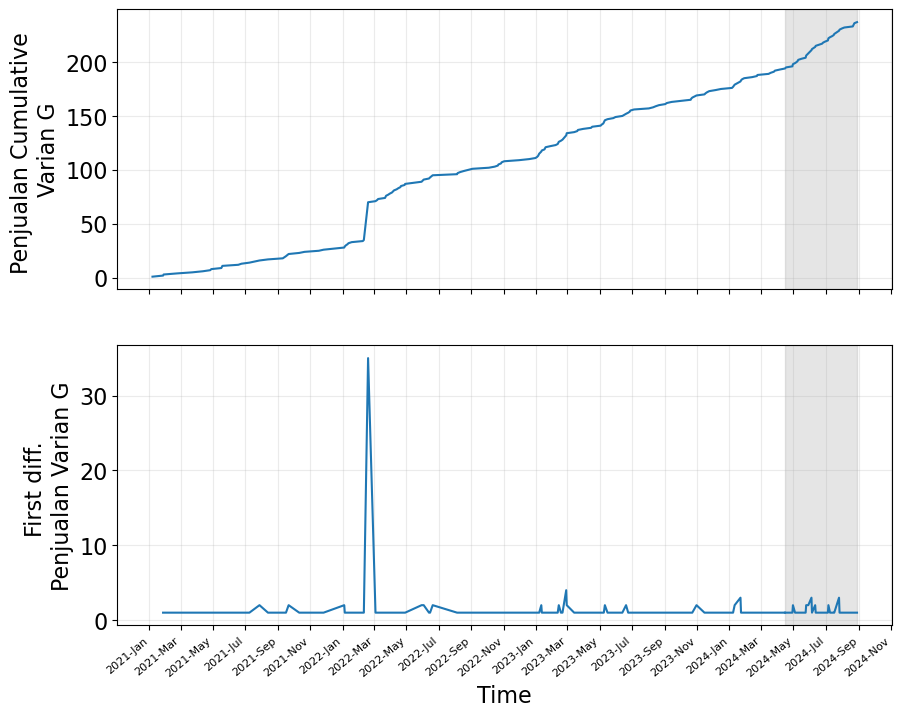

In [22]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_G_count["Tgl. Mohon"], df_G_count["cumulative_sum"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan Cumulative \nVarian G")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["G_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["G_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian G")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### Random Walk

Metode $\text{Drift}$ digunakan dalam _time series forecast_ dengan asumsi bahwa perubahan dari waktu ke waktu mengikuti tren linear. Metode ini untuk menangkap tren linier dalam data dan memberikan prediksi yang lebih baik dibandingkan metode rata-rata atau nilai terakhir ketika terdapat pola pertumbuhan atau penurunan yang konsisten. Berikut rumusnya:

$$
  \text{forecast} = \text{drift} \times \text{timestep} + y_i
$$

Keterangan:
- $ y_i $ adalah nilai awal
- $\text{drift}$ menunjukkan perubahan rata-rata per langkah waktu.

Drift dihitung sebagai kemiringan garis yang menghubungkan nilai awal $ y_i $ dengan nilai terakhir dalam data pelatihan $ y_f $:

$$
  \text{drift} = \text{slope} = \frac{h_y}{h_x} = \frac{y_f - y_i}{\text{\# timesteps} - 1}
$$

Dengan:
- $ h_y = y_f - y_i $ sebagai perubahan nilai antara titik awal dan titik akhir.
- $ h_x = \text{timesteps} - 1 $ sebagai selang waktu antara dua titik tersebut.

In [23]:
mean_train_random_walk = np.mean(df_train["G_diff"])
df_test["pred_mean"] = mean_train_random_walk

df_test.head()

,Tgl. Mohon,G_diff,pred_mean
140,2024-04-15,1,1.371429
141,2024-04-17,1,1.371429
142,2024-04-29,1,1.371429
143,2024-04-30,2,1.371429
144,2024-05-04,1,1.371429


In [24]:
last_value = df_train.iloc[-1]["G_diff"]
df_test["pred_last"] = last_value

df_test.head()

,Tgl. Mohon,G_diff,pred_mean,pred_last
140,2024-04-15,1,1.371429,1
141,2024-04-17,1,1.371429,1
142,2024-04-29,1,1.371429,1
143,2024-04-30,2,1.371429,1
144,2024-05-04,1,1.371429,1


In [25]:
h_x = len(df_train) - 1
h_y = last_value - df_train.iloc[0]["G_diff"]
drift = h_y / h_x
print(f"drift = {drift}")

drift = 0.0


In [26]:
x_vals = np.arange(1, len(df_test) + 1)   # x data for test
pred_drift = drift * x_vals + df_train.iloc[0]["G_diff"]
df_test["pred_drift"] = pred_drift

df_test.head()

,Tgl. Mohon,G_diff,pred_mean,pred_last,pred_drift
140,2024-04-15,1,1.371429,1,1.0
141,2024-04-17,1,1.371429,1,1.0
142,2024-04-29,1,1.371429,1,1.0
143,2024-04-30,2,1.371429,1,1.0
144,2024-05-04,1,1.371429,1,1.0


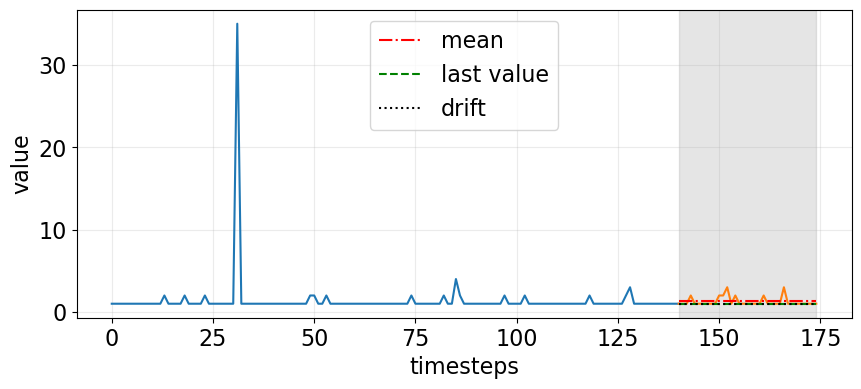

In [27]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train_extended["G_diff"])
ax.plot(df_test["G_diff"])

# forecasting
ax.plot(df_test["pred_mean"], "r-.", label="mean")
ax.plot(df_test["pred_last"], "g--", label="last value")
ax.plot(df_test["pred_drift"], "k:", label="drift")

# add forecast area (index of `test`)
ax.axvspan(140, 174,
  color="#808080", alpha=0.2
)

ax.grid("on")
ax.set_xlabel("timesteps")
ax.set_ylabel("value")

ax.legend(loc="best")

plt.show(fig)

### Evaluasi

MAE

In [28]:
mae_pred_mean   = mean_absolute_error(df_test["G_diff"], df_test["pred_mean"])
mae_pred_last   = mean_absolute_error(df_test["G_diff"], df_test["pred_last"])
mae_pred_drift  = mean_absolute_error(df_test["G_diff"], df_test["pred_drift"])

print(f"MAE mean: {mae_pred_mean}")
print(f"MAE last: {mae_pred_last}")
print(f"MAE drif: {mae_pred_drift}")

MAE mean: 0.4799999999999999
MAE last: 0.2571428571428571
MAE drif: 0.2571428571428571


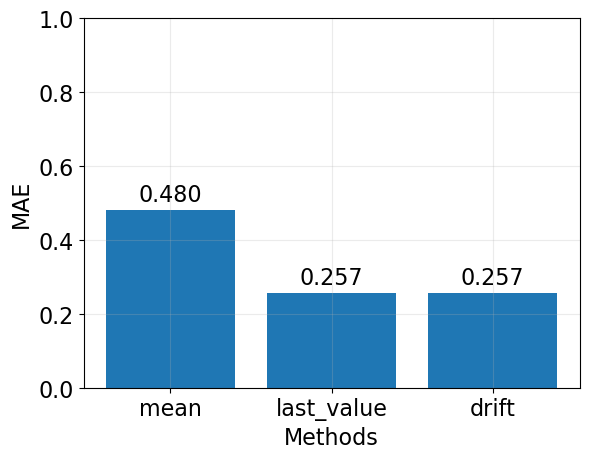

In [29]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mae_pred_mean, mae_pred_last, mae_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 1])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [30]:
mse_pred_mean  = mean_squared_error(df_test["G_diff"], df_test["pred_mean"])
mse_pred_last  = mean_squared_error(df_test["G_diff"], df_test["pred_last"])
mse_pred_drift = mean_squared_error(df_test["G_diff"], df_test["pred_drift"])

print(f"MSE mean: {mse_pred_mean}")
print(f"MSE last: {mse_pred_last}")
print(f"MSE drif: {mse_pred_drift}")

MSE mean: 0.3183673469387755
MSE last: 0.37142857142857144
MSE drif: 0.37142857142857144


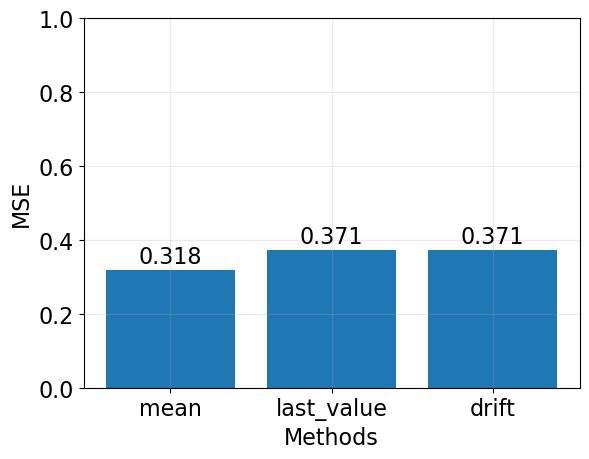

In [31]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mse_pred_mean, mse_pred_last, mse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 1])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

RMSE

In [32]:
rmse_pred_mean = np.sqrt(mse_pred_mean)
rmse_pred_last = np.sqrt(mse_pred_last)
rmse_pred_drift= np.sqrt(mse_pred_drift)

print(f"RMSE mean: {rmse_pred_mean}")
print(f"RMSE last: {rmse_pred_last}")
print(f"RMSE drif: {rmse_pred_drift}")

RMSE mean: 0.5642405045180429
RMSE last: 0.609449400220044
RMSE drif: 0.609449400220044


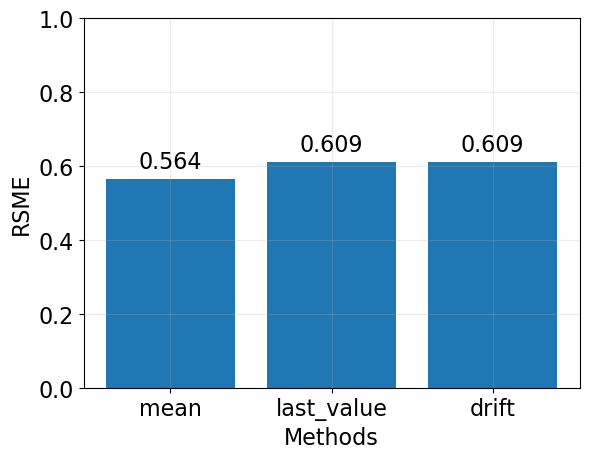

In [33]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [rmse_pred_mean, rmse_pred_last, rmse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RSME")
ax.set_ylim([0, 1])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [34]:
mape_pred_mean  = mean_absolute_percentage_error(df_test["G_diff"], df_test["pred_mean"]) * 100 
mape_pred_last  = mean_absolute_percentage_error(df_test["G_diff"], df_test["pred_last"]) * 100
mape_pred_drif  = mean_absolute_percentage_error(df_test["G_diff"], df_test["pred_drift"]) * 100

print(f"MAPE mean: {mape_pred_mean:5.2f}%")
print(f"MAPE last: {mape_pred_last:5.2f}%")
print(f"MAPE drift: {mape_pred_drif:5.2f}%")

MAPE mean: 37.31%
MAPE last: 10.95%
MAPE drift: 10.95%


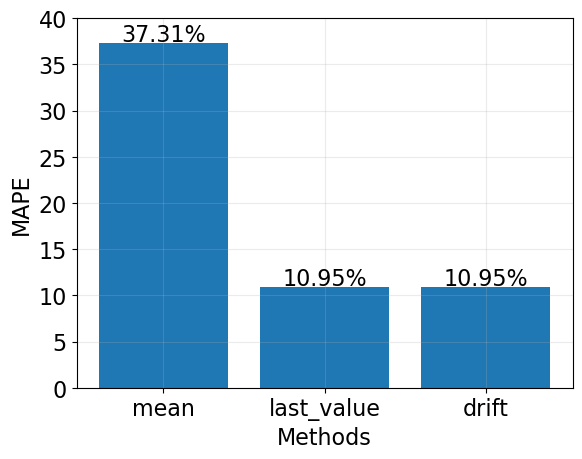

In [35]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mape_pred_mean, mape_pred_last, mape_pred_drif]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 40])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [36]:
naive = np.abs(np.diff(df_train["G_diff"])).mean()

mase_pred_mean = mae_pred_mean / naive
mase_pred_last = mae_pred_last / naive
mase_pred_drift  = mae_pred_drift / naive

print(f"MASE mean: {mase_pred_mean}")
print(f"MASE last: {mase_pred_last}")
print(f"MASE drift: {mase_pred_drift}")

MASE mean: 0.6808163265306122
MASE last: 0.3647230320699708
MASE drift: 0.3647230320699708


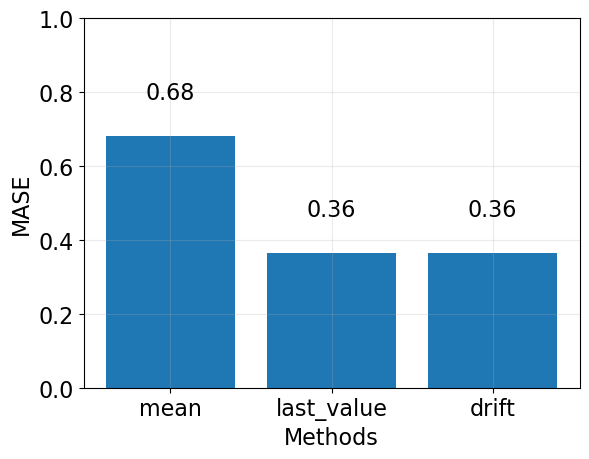

In [37]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mase_pred_mean, mase_pred_last, mase_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 1])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)